# Plotting the rawdata of min mslp and tp

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import psutil
import datetime
import time as tm
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patheffects as pe
import xarray as xr

In [2]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs


expname = {
      1: 'CTL',    
      2: 'T+4K',
      3: 'T+4K_RH-',
      4: 'T+anom',
      5: 'T+TRanom',
      6: 'T+POanom'
         }

exp80 = { 
      1:'channel_80km_0001',
      2:'channel_80km_0002',
      3:'channel_80km_0003',
      4:'channel_80km_0004',
      5:'channel_80km_0005',
      6:'channel_80km_0006',
      }

exp2 = { 
      1:'channel_2km_0001',
      2:'channel_2km_0002',
      3:'channel_2km_0003',
      4:'channel_2km_0004',
      5:'channel_2km_0005',
      6:'channel_2km_0006',
      }


we load libraries

In [3]:
# path on mistral
ipath = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_center_maps/'
ipathPTEmap = '/work/bb1152/Module_A/A6_CyclEx/pp_data/PTE_maps/'

tp_ext  ={}
wdsp_ext={}
tp_avg  ={}
wdsp_avg={}
deeprate_avg={}
sumdpcore_avg={}
tpavg_change={}
wdspavg_change={}
perc=99
Large_box = 41 
#core_box = 7 
core_box = 3 
# Original dimension for the cyclone-center composites:  53x53 

gst  = int((41-Large_box)*0.5)
gen  = int(gst+Large_box)
gstc = int((41-core_box)*0.5)
genc = int(gstc+core_box)

print (gst, gen)
print (gstc, genc)
# read the data
for exp in range(1,7,1):
    ifile1    = "Cyclone_center_map_for_"+exp80[exp]+".nc"
    ifile1pte = "CCenter_PTE_map_for_"+exp80[exp]+"_6hrly_1x1latlon_upper50hPa.nc"
    nc1       = Dataset(ipath+ifile1, mode='r')
    nc1pte    = Dataset(ipathPTEmap+ifile1pte, mode='r')
    
    time      = nc1.variables['time'][:]+1
    #timepte   = nc1pte.variables['time'][:] # the first 6 timesteps have been removed
    print(time)
    #lon     = nc1.variables['lon'][:]
    #lat1     = nc1.variables['lat'][:]
    #mslp[exp80[exp]]    = nc1.variables['mslp'][:]  
    #precip[exp80[exp]]  = nc1.variables['precip'][:]
    tp       = nc1.variables['precip'][:,gst:gen,gst:gen] # Original dimension: 31, 53, 53 
                                              # I set a box of 40x40 degree here because sometimes the 
                                                # cyclone center gets too close to the northern boundary                                     
    #print(tp.shape)
    u1       = nc1.variables['u10m'][:,gst:gen,gst:gen]
    v1       = nc1.variables['v10m'][:,gst:gen,gst:gen]
    #u1       = nc1.variables['u850'][:,gst:gen,gst:gen]
    #v1       = nc1.variables['v850'][:,gst:gen,gst:gen]
    dp       = nc1pte.variables['Cdp'][:,gstc:genc,gstc:genc]
    
    wdsp850 = np.zeros_like(u1)
    nx = u1.shape[1]
    ny = u1.shape[2]
    for i in range(nx):
        for j in range(ny):
            wdsp850[:,i,j]  = (u1[:,i,j]**2.+v1[:,i,j]**2.)**0.5
    
    wdspext  = np.full((len(time)),np.nan,dtype=float)
    tpext    = np.full((len(time)),np.nan,dtype=float)
    wdspavg  = np.full((len(time)),np.nan,dtype=float)
    tpavg    = np.full((len(time)),np.nan,dtype=float)
    coredeep    = np.full((len(time)),np.nan,dtype=float)
    sumdpcore= np.full((len(time)),np.nan,dtype=float)
    tpavg_cha= np.full((len(time)),np.nan,dtype=float)
    wdspavg_cha= np.full((len(time)),np.nan,dtype=float)
    for t in range(0,len(time)):
        tpext[t]   = np.percentile(tp[t,:,:],perc)
        wdspext[t] = np.percentile(wdsp850[t,:,:],perc)
        tpavg[t]   = np.average(tp[t,:,:])
        wdspavg[t] = np.average(wdsp850[t,:,:]) 
        coredeep[t]= np.average(dp[t,:,:]) 
    sumdp=0.
    for t in range(1,len(time)):
        for i in range (1,t):
            sumdp = sumdp + coredeep[i]
        sumdpcore[t]=sumdp
        tpavg_cha[t]   = tpavg[t]-tpavg[t-1]
        wdspavg_cha[t]   = wdspavg[t]-wdspavg[t-1]
        
    tp_ext[exp80[exp]] = tpext
    wdsp_ext[exp80[exp]] = wdspext
    tp_avg[exp80[exp]] = tpavg
    wdsp_avg[exp80[exp]] = wdspavg
    deeprate_avg[exp80[exp]] = coredeep
    sumdpcore_avg[exp80[exp]] = sumdpcore
    tpavg_change[exp80[exp]] = tpavg_cha
    wdspavg_change[exp80[exp]] = wdspavg_cha
    
    nc1.close()
    nc1pte.close()
    #------------------------------------------
    ifile2    = "Cyclone_center_map_for_"+exp2[exp]+".nc"
    ifile2pte = "CCenter_PTE_map_for_"+exp2[exp]+"_6hrly_1x1latlon_upper50hPa.nc"
    nc2       = Dataset(ipath+ifile2, mode='r')
    nc2pte    = Dataset(ipathPTEmap+ifile2pte, mode='r')
    time      = nc2.variables['time'][:]+1
    #timepte   = nc2pte.variables['time'][:]
    #lon     = nc1.variables['lon'][:]
    #lat1     = nc1.variables['lat'][:]
    #mslp[exp2[exp]]    = nc2.variables['mslp'][:]  
    tp       = nc2.variables['precip'][:,gst:gen,gst:gen]
    u2       = nc2.variables['u10m'][:,gst:gen,gst:gen]
    v2       = nc2.variables['v10m'][:,gst:gen,gst:gen]
    #u2       = nc2.variables['u850'][:,gst:gen,gst:gen]
    #v2       = nc2.variables['v850'][:,gst:gen,gst:gen]
    dp       = nc2pte.variables['Cdp'][:,gstc:genc,gstc:genc]
 
    wdsp850 = np.zeros_like(u2)
    nx = u2.shape[1]
    ny = u2.shape[2]
    for i in range(nx):
        for j in range(ny):
            wdsp850[:,i,j]  = (u2[:,i,j]**2.+v2[:,i,j]**2.)**0.5
    #wdsp850  = (u2**2.*v2**2.)**0.5
    
    wdspext  = np.full((len(time)),np.nan,dtype=float)
    tpext    = np.full((len(time)),np.nan,dtype=float)
    wdspavg  = np.full((len(time)),np.nan,dtype=float)
    tpavg    = np.full((len(time)),np.nan,dtype=float)
    coredeep = np.full((len(time)),np.nan,dtype=float)
    sumdpcore= np.full((len(time)),np.nan,dtype=float)
    tpavg_cha= np.full((len(time)),np.nan,dtype=float)
    wdspavg_cha= np.full((len(time)),np.nan,dtype=float)
    for t in range(0,len(time)):
        tpext[t]   = np.percentile(tp[t,:,:],perc)
        wdspext[t] = np.percentile(wdsp850[t,:,:],perc)
        tpavg[t]   = np.average(tp[t,:,:])
        wdspavg[t] = np.average(wdsp850[t,:,:])   
        coredeep[t]= np.average(dp[t,:,:])
    sumdp=0.
    for t in range(1,len(time)):
        for i in range (1,t):
            sumdp = sumdp + coredeep[i]
        sumdpcore[t]=sumdp
        tpavg_cha[t]   = tpavg[t]-tpavg[t-1]
        wdspavg_cha[t]   = wdspavg[t]-wdspavg[t-1]
    tp_ext[exp2[exp]] = tpext
    wdsp_ext[exp2[exp]] = wdspext
    tp_avg[exp2[exp]] = tpavg
    wdsp_avg[exp2[exp]] = wdspavg
    deeprate_avg[exp2[exp]] = coredeep
    sumdpcore_avg[exp2[exp]] = sumdpcore
    tpavg_change[exp2[exp]] = tpavg_cha
    wdspavg_change[exp2[exp]] = wdspavg_cha
    nc2.close()
    nc2pte.close()
#print(len(tp_ext[exp2[1]]))
print(deeprate_avg[exp80[1]])
print(deeprate_avg[exp80[5]])
print(sumdpcore_avg[exp80[5]])

0 41
19 22
[ 2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25
  5.5   5.75  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25
  8.5   8.75  9.    9.25  9.5   9.75 10.  ]
[ 2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25
  5.5   5.75  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25
  8.5   8.75  9.    9.25  9.5   9.75 10.  ]
[ 2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25
  5.5   5.75  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25
  8.5   8.75  9.    9.25  9.5   9.75 10.  ]
[ 2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25
  5.5   5.75  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25
  8.5   8.75  9.    9.25  9.5   9.75 10.  ]
[ 2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25
  5.5   5.75  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25
  8.5   8.75  9.    9.25  9.5   9.75 10.  ]
[ 2.5   2.75  3.    3.25  3.5   3.75  4

In [4]:
deeprate={}
track_time={}
track_dp={}

for exp in range(1,7):    
    path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'
    df_track1 = pd.read_csv(path_track+'Track_for_'+exp80[exp]+'_6hrly_1x1latlon.csv')
    df_track2 = pd.read_csv(path_track+'Track_for_'+exp2[exp]+'_6hrly_1x1latlon.csv')
    track_dur   = df_track1['time']+1
    track_pmin1 = df_track1['pmin'].to_numpy()
    #track_dur2  = df_track2['time']+1
    track_pmin2 = df_track2['pmin'].to_numpy()
    #print('time=',track_dur)

    #deeprate1   = np.full((len(track_dur)),np.nan,dtype=float)
    #deeprate2   = np.full((len(track_dur)),np.nan,dtype=float)
    #tracktime   = np.full((len(track_dur)),np.nan,dtype=float)
    
    deeprate1   = np.full((len(time)),np.nan,dtype=float)
    deeprate2   = np.full((len(time)),np.nan,dtype=float)
    tracktime   = np.full((len(time)),np.nan,dtype=float)
    for t in range(0,len(time)):
        tracktime[t] = track_dur[t+6]
        deeprate1[t] = (track_pmin1[t+6]-track_pmin1[t+6-1])
        deeprate2[t] = (track_pmin2[t+6]-track_pmin2[t+6-1])
    deeprate[exp80[exp]]=deeprate1
    deeprate[exp2[exp]]=deeprate2
    track_time[exp80[exp]] = tracktime
    track_time[exp2[exp]] = tracktime
    track_dp[exp80[exp]] = track_pmin1[6:len(track_dur)]
    track_dp[exp2[exp]] = track_pmin2[6:len(track_dur)]
print(track_time[exp2[1]])
print(track_time[exp2[1]][2:26])

[ 2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25
  5.5   5.75  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25
  8.5   8.75  9.    9.25  9.5   9.75 10.  ]
[3.   3.25 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25
 6.5  6.75 7.   7.25 7.5  7.75 8.   8.25 8.5  8.75]


Pearsons correlation: 0.488
Spearmans correlation: 0.488
Pearsons correlation: 0.593
Spearmans correlation: 0.611


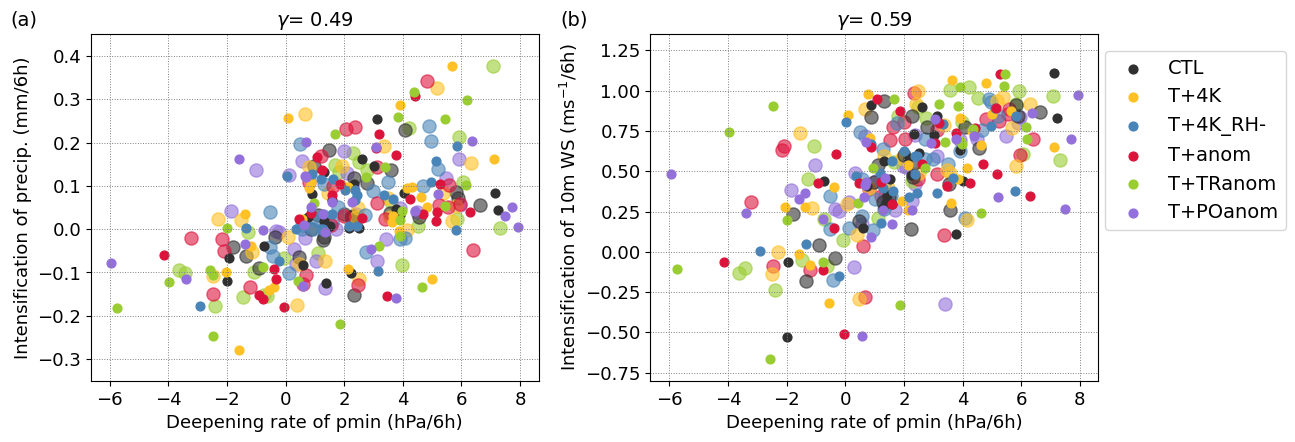

In [5]:
from scipy.stats import pearsonr, spearmanr

#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
colors={1:'#303030',2:'#FFC125',3:'#4984b8',4:'crimson',5:'yellowgreen',6:'mediumpurple'}


fs=10

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(13, 4.5))

ax1 = plt.subplot(1,2,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in [5,6,1,2,3,4]: 
    plt.scatter(-deeprate[exp80[i]][2:26],tpavg_change[exp80[i]][2:26],c=colors[i], s=90, marker='o',alpha=0.6) 
for i in [1,2,3,4,5,6]: 
    plt.scatter(-deeprate[exp2[i]][2:26],tpavg_change[exp2[i]][2:26],c=colors[i], s=40, marker='o',alpha=1) 


deeprateavg_all=[]
tpavgchange_all=[]
# calculate Pearson's correlation
for i in range(1,7,1):
    deeprateavg_all.extend(-deeprate[exp80[i]][2:26])
    deeprateavg_all.extend(-deeprate[exp2[i]][2:26])
    #print(deeprateavg_all)
    tpavgchange_all.extend(tpavg_change[exp80[i]][2:26])
    tpavgchange_all.extend(tpavg_change[exp2[i]][2:26])
corrp, _ = pearsonr(deeprateavg_all, tpavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, tpavgchange_all)
print('Spearmans correlation: %.3f' % corrs)
    #plt.plot(time,minmslp[exp2[i]]/100.,color=colors[i],linestyle=':',linewidth=2.5,alpha=1) 
#ax1.set_xlim(time[0],time[ntimes-1])
#ax1.set_ylabel('hPa',fontsize=fs)
#ax1.set_xticks(np.arange(3,10,1))
#ax1.set_ylim(0,1.3)
#plt.xticks(np.arange(1,11,1))
#plt.legend(fontsize=fs)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(-0.35, 0.45)
#plt.xlim(0.8, 10.1)
plt.xlabel('Deepening rate of pmin (hPa/6h)',fontsize=13)
plt.ylabel('Intensification of precip. (mm/6h)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('Minimum mslp in the domain', fontsize=14)
#plt.savefig('Rawdata_domain_pmin_2km_vs_80km.png', bbox_inches='tight', dpi=100)
plt.title(''r'$\gamma$= %.2f' % corrp, fontsize=14)
plt.text(-0.12, 1.07, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=14) 

ax1 = plt.subplot(1,2,2)
for i in range(6,0,-1):
    plt.scatter(-deeprate[exp80[i]][2:26],wdspavg_change[exp80[i]][2:26],c=colors[i], vmin=0, vmax=8, s=90, marker='o',alpha=0.6) 
for i in range(1,7):
    plt.scatter(-deeprate[exp2[i]][2:26],wdspavg_change[exp2[i]][2:26],c=colors[i], vmin=0, vmax=8, s=40, marker='o',alpha=1,label=expname[i]) 

    
ax1.legend(fontsize=14, columnspacing=0.,bbox_to_anchor=(1.44, 0.98))

wdspavgchange_all=[]
# calculate Pearson's correlation
for i in range(1,7,1):
    wdspavgchange_all.extend(wdspavg_change[exp80[i]][2:26])
    wdspavgchange_all.extend(wdspavg_change[exp2[i]][2:26])
corrp, _ = pearsonr(deeprateavg_all, wdspavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, wdspavgchange_all)
print('Spearmans correlation: %.3f' % corrs)

    #plt.plot(time,minmslp[exp2[i]]/100.,color=colors[i],linestyle=':',linewidth=2.5,alpha=1) 
#ax1.set_xlim(time[0],time[ntimes-1])
#ax1.set_ylabel('hPa',fontsize=fs)
#ax1.set_xticks(np.arange(3,10,1))
ax1.set_ylim(-0.8,1.35)
#plt.xticks(np.arange(1,11,1))
#plt.legend(fontsize=fs)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
plt.xlabel('Deepening rate of pmin (hPa/6h)',fontsize=13)
plt.ylabel('Intensification of 10m WS (m'r'$\mathrm{s}^{-1}$''/6h)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title(''r'$\gamma$= %.2f' % corrp, fontsize=14)


plt.text(-0.14, 1.07, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=14) 

plt.subplots_adjust(wspace = 0.25)


plt.savefig('Fig_DeepeningrateLagrangian_averaged_precipitation_10mwdsp_change_relation.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

80km
i= 1
maximum wdsp_avg: 13.198654174804688
maximum tp_avg: 1.162032961845398
80km
i= 2
maximum wdsp_avg: 14.073781967163086
maximum tp_avg: 1.5540289878845215
80km
i= 3
maximum wdsp_avg: 13.104056358337402
maximum tp_avg: 1.282334804534912
80km
i= 4
maximum wdsp_avg: 13.767343521118164
maximum tp_avg: 1.5915833711624146
2km
i= 1
maximum wdsp_avg: 13.043327331542969
maximum tp_avg: 1.201887607574463
2km
i= 2
maximum wdsp_avg: 14.044476509094238
maximum tp_avg: 1.6689435243606567
2km
i= 3
maximum wdsp_avg: 12.766310691833496
maximum tp_avg: 1.3577739000320435
2km
i= 4
maximum wdsp_avg: 13.584153175354004
maximum tp_avg: 1.61427903175354
80km
i= 1
maximum wdsp_ext: 22.257909774780273
maximum tp_ext: 14.195768737792973
80km
i= 2
maximum wdsp_ext: 22.984524154663095
maximum tp_ext: 21.45597877502442
80km
i= 3
maximum wdsp_ext: 22.326977157592772
maximum tp_ext: 16.08075523376467
80km
i= 4
maximum wdsp_ext: 23.980833435058596
maximum tp_ext: 21.972449111938484
2km
i= 1
maximum wdsp_ext: 

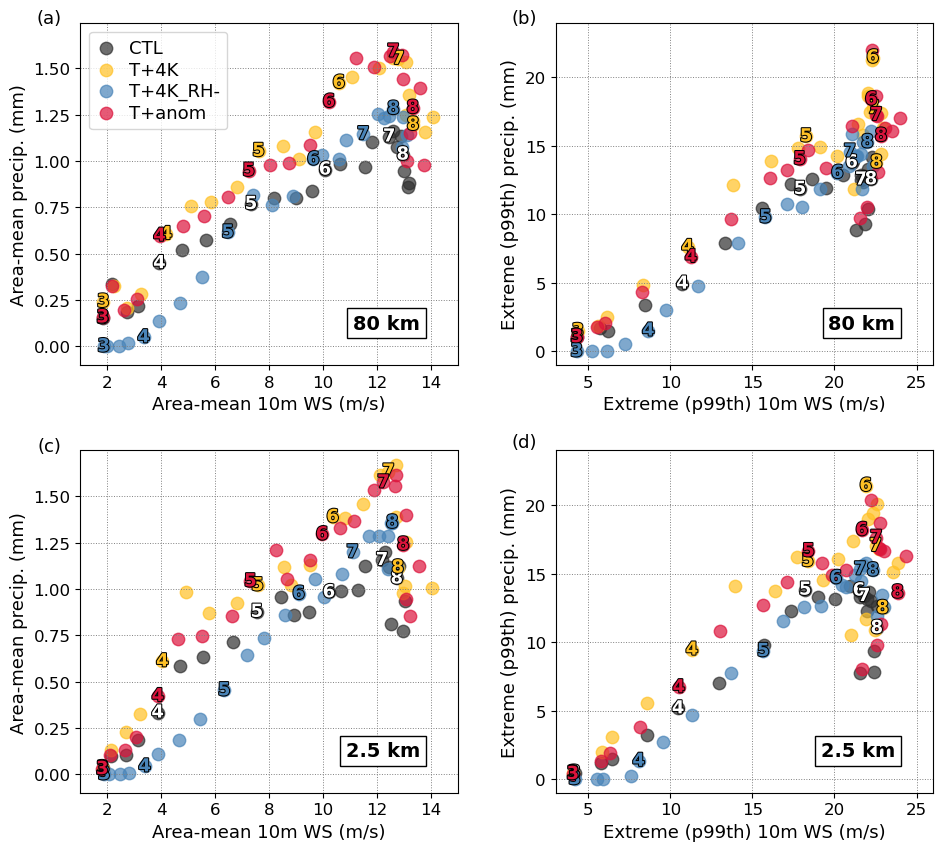

In [28]:
import matplotlib.patheffects as pe
#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
#colors={1:'dimgray',2:'gold',3:'royalblue',4:'crimson',5:'darkorange',6:'mediumseagreen'}

colors2={1:'white',2:'#FFC125',3:'#4984b8',4:'crimson',5:'yellowgreen',6:'mediumpurple'}

#colors={1:'k',2:'#FFC125',3:'#4984b8',4:'crimson',5:'gold',6:'mediumseagreen'}
colors={1:'#303030',2:'#FFC125',3:'#4984b8',4:'crimson',5:'yellowgreen',6:'mediumpurple'}

colorsedge={1:'k',2:'k',3:'k',4:'k',5:'yellowgreen',6:'mediumpurple'}
#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}

fs=13

classes= ['CTL', '4K', '4K_RH-','Tanom','Tanom_TR','Tanom_PO']

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(11, 10))


ax1 = plt.subplot(2,2,1)


#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,5,1):
#for i in [1,4,5,6]:
    print ('80km')
    print ('i=', i)
    print ('maximum wdsp_avg:', np.max(wdsp_avg[exp80[i]][2:26]))
    print ('maximum tp_avg:', np.max(tp_avg[exp80[i]][2:26]))
    plt.scatter(wdsp_avg[exp80[i]][2:26],tp_avg[exp80[i]][2:26],#s=(track_dp[exp80[i]][2:26]-920)*2,
                s=80,
                c=colors[i], label=expname[i], vmin=0, vmax=8, marker='o',alpha=0.7) 
    
    for jj in range(len(wdsp_avg[exp80[i]][2:26:4])):
        plt.annotate(''+str('{:01.0f}'.format(track_time[exp80[i]][2+jj*4]))+'', (wdsp_avg[exp80[i]][2+jj*4], tp_avg[exp80[i]][2+jj*4]),
                        color=colors2[i],ha='center',va='center',fontsize=fs,fontweight='bold', zorder=500,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground=colorsedge[i])])
    
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Area-mean precip. (mm)',fontsize=13)
#plt.xlabel('P98th 850-hPa wdsp (m/s)',fontsize=13)
plt.xlabel('Area-mean 10m WS (m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('80 km', fontsize=14, y=0.99)
plt.ylim(-0.1, 1.747)
plt.xlim(1, 15)
plt.legend(loc="upper left",fontsize=13,handlelength=1.0,labelspacing=0.2)
plt.text(0.9, 0.15,
         '80 km',ha='right',va='top', 
         weight='bold',fontsize=14,
         bbox=dict(ec='k',fc='white'),
                 transform=ax1.transAxes, zorder=50)
#plt.text(0.9, 0.15, '80 km', ha='right', va='top', transform=ax1.transAxes, fontsize=15, color='dimgray',fontweight='bold') 
plt.text(-0.05, 1.04, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 

ax2 = plt.subplot(2,2,3)    
#for i in [1,4,5,6]:
for i in range(1,5,1):
    print ('2km')
    print ('i=', i)
    print ('maximum wdsp_avg:', np.max(wdsp_avg[exp2[i]][2:26]))
    print ('maximum tp_avg:', np.max(tp_avg[exp2[i]][2:26]))
    scatter = plt.scatter(wdsp_avg[exp2[i]][2:26],tp_avg[exp2[i]][2:26],c=colors[i],#s=(track_dp[exp2[i]][2:26]-920)*2,  
                          s=80,vmin=0, vmax=8,marker='o',alpha=0.7) 
    

    for jj in range(len(wdsp_ext[exp2[i]][2:26:4])):
        plt.annotate(''+str('{:01.0f}'.format(track_time[exp2[i]][2+jj*4]))+'', (wdsp_avg[exp2[i]][2+jj*4], tp_avg[exp2[i]][2+jj*4]),
                        color=colors2[i],ha='center',va='center',fontsize=fs,fontweight='bold', zorder=500,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground=colorsedge[i])])

    #ax2.legend()



plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(-0.1, 1.747)
plt.xlim(1, 15)
plt.ylabel('Area-mean precip. (mm)',fontsize=13)
#plt.xlabel('P98th 850-hPa wdsp (m/s)',fontsize=13)
plt.xlabel('Area-mean 10m WS (m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('2 km', fontsize=14,  y=0.99)
plt.text(0.9, 0.15,
         '2.5 km',ha='right',va='top', 
         weight='bold',fontsize=14,
         bbox=dict(ec='k',fc='white'),
                 transform=ax2.transAxes, zorder=50)
#plt.text(0.9, 0.15, '2 km', ha='right', va='top', transform=ax2.transAxes, fontsize=15, color='dimgray',fontweight='bold') 
plt.text(-0.05, 1.04, '(c)', ha='right', va='top', transform=ax2.transAxes, fontsize=13) 

ax1 = plt.subplot(2,2,2)

#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,5,1):
    print ('80km')
    print ('i=', i)
    print ('maximum wdsp_ext:', np.max(wdsp_ext[exp80[i]][2:26]))
    print ('maximum tp_ext:', np.max(tp_ext[exp80[i]][2:26]))
#for i in [4]:
    plt.scatter(wdsp_ext[exp80[i]][2:26],tp_ext[exp80[i]][2:26],#s=(track_dp[exp80[i]][2:26]-920)*2,
                s=80,
                c=colors[i],  label=expname[i], vmin=0, vmax=8, marker='o',alpha=0.7) 

   
    for jj in range(len(wdsp_ext[exp80[i]][2:26:4])):
        plt.annotate(''+str('{:01.0f}'.format(track_time[exp80[i]][2+jj*4]))+'', (wdsp_ext[exp80[i]][2+jj*4], tp_ext[exp80[i]][2+jj*4]),
                        color=colors2[i],ha='center',va='center',fontsize=fs,fontweight='bold', zorder=500,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground=colorsedge[i])])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Extreme (p99th) precip. (mm)',fontsize=13)
plt.xlabel('Extreme (p99th) 10m WS (m/s)',fontsize=13)
#plt.xlabel('Averaged 850-hPa wdsp',fontsize=13)

plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('80 km', fontsize=14,  y=0.99)

#plt.ylim(-1, 21)
plt.ylim(-1, 24)
plt.xlim(3, 26)

#plt.legend(loc="upper left",fontsize=13)
plt.text(0.9, 0.15,
         '80 km',ha='right',va='top', 
         weight='bold',fontsize=14,
         bbox=dict(ec='k',fc='white'),
                 transform=ax1.transAxes, zorder=50)
#plt.text(0.9, 0.15, '80 km', ha='right', va='top', transform=ax1.transAxes, fontsize=15, color='dimgray',fontweight='bold') 
plt.text(-0.05, 1.04, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 

ax2 = plt.subplot(2,2,4)    
for i in range(1,5,1):
#for i in [1,4,5,6]:
    print ('2km')
    print ('i=', i)
    print ('maximum wdsp_ext:', np.max(wdsp_ext[exp2[i]][2:26]))
    print ('maximum tp_ext:', np.max(tp_ext[exp2[i]][2:26]))
    scatter = plt.scatter(wdsp_ext[exp2[i]][2:26],tp_ext[exp2[i]][2:26],c=colors[i],#s=(track_dp[exp80[i]][2:26]-920)*2,  
                          s=80,vmin=0, vmax=8,marker='o',alpha=0.7)
    
   
    for jj in range(len(wdsp_ext[exp2[i]][2:26:4])):
        plt.annotate(''+str('{:01.0f}'.format(track_time[exp2[i]][2+jj*4]))+'', (wdsp_ext[exp2[i]][2+jj*4], tp_ext[exp2[i]][2+jj*4]),
                        color=colors2[i],ha='center',va='center',fontsize=fs,fontweight='bold', zorder=500,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground=colorsedge[i])])
    
    #plt.text(wdsp_avg[exp2[i]][2:26:4],tp_avg[exp2[i]][2:26:4]+0.25,'test')
             #''+str(track_time[exp2[i]][2:26:4])+'', 
    #                    color=colors[i],ha='center',va='center',fontsize=13, zorder=500)
#ax2.legend()

#plt.legend(handles=scatter.legend_elements(prop="colors"), loc="upper left")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-1, 24)
plt.xlim(3, 26)
#plt.xlim(0.8, 10.1)
plt.ylabel('Extreme (p99th) precip. (mm)',fontsize=13)
plt.xlabel('Extreme (p99th) 10m WS (m/s)',fontsize=13)
#plt.xlabel('Averaged 850-hPa wdsp (m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)

#plt.text(0.9, 0.15, '2 km', ha='right', va='top', transform=ax2.transAxes, fontsize=15, color='dimgray',fontweight='bold') 
plt.text(0.9, 0.15,
         '2.5 km',ha='right',va='top', 
         weight='bold',fontsize=14,
         bbox=dict(ec='k',fc='white'),
                 transform=ax2.transAxes, zorder=50)
plt.text(-0.05, 1.05, '(d)', ha='right', va='top', transform=ax2.transAxes, fontsize=13) 

plt.subplots_adjust(wspace=0.26, hspace=0.25)
plt.savefig('Fig5_scatter_tp_10mwdsp_p99_and_avg_2km_vs_80km_EXP1-4.png', bbox_inches='tight', dpi=100)

plt.show()
plt.close()

In [7]:
# FOR SUPPLEMENTARY MATERIAL ================================

#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
fs=12

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(13, 4))
ax1 = plt.subplot(1,2,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,7,1):
    if i >= 5: 
        plt.plot(track_time[exp80[i]],deeprate[exp80[i]],color=colors[i],linewidth=1.5,alpha=0.8) 
    else:
        plt.plot(track_time[exp80[i]],deeprate[exp80[i]],color=colors[i],linewidth=2.5,alpha=0.8) 
plt.axhline(y=0, color='k', linestyle='-', lw=0.5)
    #plt.plot(time,wdsp98[exp2[i]],color=colors[i],linestyle=':',linewidth=2.5,alpha=1) 
#ax1.set_xlim(time[0],time[ntimes-1])
#ax1.set_ylabel('hPa',fontsize=fs)
#ax1.set_xticks(np.arange(3,10,1))

#plt.xticks(np.arange(1,11,1))
#plt.legend(fontsize=fs)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(2.5, 9)
plt.ylim(-19, 7)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
#plt.ylim(-2, 25)
plt.xlabel('Day (initialized from day 1)',fontsize=12)
plt.ylabel('(hPa/6h)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Deepening rate of cyclone center (Lagragian)', fontsize=14)

ax2 = plt.subplot(1,2,2)
for i in range(1,7,1):
    if i >=5: 
        plt.plot(time,deeprate_avg[exp80[i]],color=colors[i],linewidth=1.5,alpha=0.8) 
    else: 
        plt.plot(time,deeprate_avg[exp80[i]],color=colors[i],linewidth=2.5,alpha=0.8) 
plt.axhline(y=0, color='k', linestyle='-', lw=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-19, 7)
plt.xlim(2.5, 9)
#plt.xlim(0.8, 10.1)
#plt.ylim(-2, 25)
plt.xlabel('Day (initialized from day 1)',fontsize=12)
plt.ylabel('(hPa/6h)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Dp averaegd over 6x6 box (Semi-Lagragian)', fontsize=14)

plt.savefig('FigSDeepening_rate_Lagrangian_vs_semiLagragian_80km.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

In [8]:
# FOR BACKUP ========================
#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
fs=12

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(13, 4))
ax1 = plt.subplot(1,2,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,7,1):
    if i >= 5: 
        plt.plot(track_time[exp2[i]],deeprate[exp2[i]],color=colors[i],linewidth=1.5,alpha=0.8) 
    else:
        plt.plot(track_time[exp2[i]],deeprate[exp2[i]],color=colors[i],linewidth=2.5,alpha=0.8) 
plt.axhline(y=0, color='k', linestyle='-', lw=0.5)
    #plt.plot(time,wdsp98[exp2[i]],color=colors[i],linestyle=':',linewidth=2.5,alpha=1) 
#ax1.set_xlim(time[0],time[ntimes-1])
#ax1.set_ylabel('hPa',fontsize=fs)
#ax1.set_xticks(np.arange(3,10,1))

#plt.xticks(np.arange(1,11,1))
#plt.legend(fontsize=fs)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(2.5, 9)
plt.ylim(-21, 7)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
#plt.ylim(-2, 25)
plt.xlabel('Day (initialized from day 1)',fontsize=12)
plt.ylabel('(hPa/6h)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Deepening rate of cyclone center (Lagragian)', fontsize=14)

ax2 = plt.subplot(1,2,2)
for i in range(1,7,1):
    if i >= 5: 
        plt.plot(time,deeprate_avg[exp2[i]],color=colors[i],linewidth=1.5,alpha=0.8) 
    else:
        plt.plot(time,deeprate_avg[exp2[i]],color=colors[i],linewidth=2.5,alpha=0.8) 
plt.axhline(y=0, color='k', linestyle='-', lw=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(2.5, 9)
plt.ylim(-21, 7)
#plt.xlim(0.8, 10.1)
#plt.ylim(-2, 25)
plt.xlabel('Day (initialized from day 1)',fontsize=12)
plt.ylabel('(hPa/6h)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Dp averaegd over 6x6 box (Semi-Lagragian)', fontsize=14)

#plt.savefig('Deepening_rate_Lagrangian_vs_semiLagragian_2km.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

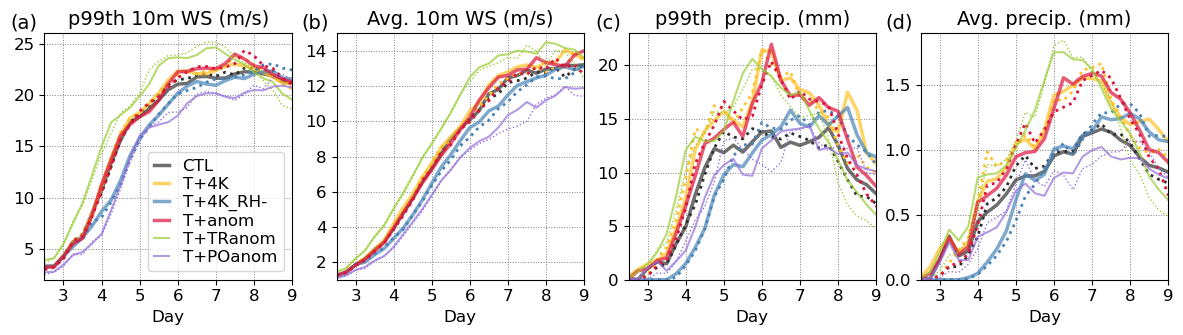

In [9]:
# FOR SUPPLEMENTARY MATERIAL ================================

#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
fs=12

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(14.5, 3.2))

ax1 = plt.subplot(1,4,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,7,1):
    if i >=5:
        plt.plot(time,wdsp_ext[exp80[i]],color=colors[i],linewidth=1.5,alpha=0.7, label=expname[i]) 
        plt.plot(time,wdsp_ext[exp2[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    else: 
        plt.plot(time,wdsp_ext[exp80[i]],color=colors[i],linewidth=2.5,alpha=0.7,label=expname[i]) 
        plt.plot(time,wdsp_ext[exp2[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(2.5,9)
plt.ylim(2,26)
plt.xlabel('Day',fontsize=12)
#plt.ylabel('(m/s)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('p99th 10m WS (m/s)', fontsize=14)
#plt.title('P98th 850-hPa wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=14) 
plt.legend(loc="lower right",fontsize=12,labelspacing=0.18,handlelength=0.9)
ax1.xaxis.set_ticks(np.arange(3, 10, 1))

ax1 = plt.subplot(1,4,2)
for i in range(1,7,1):
    if i >=5:
        plt.plot(time,wdsp_avg[exp80[i]],color=colors[i],linewidth=1.5,alpha=0.7) 
        plt.plot(time,wdsp_avg[exp2[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    else:
        plt.plot(time,wdsp_avg[exp80[i]],color=colors[i],linewidth=2.5,alpha=0.7) 
        plt.plot(time,wdsp_avg[exp2[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(2.5,9)
plt.ylim(1,15)
plt.xlabel('Day',fontsize=12)
#plt.ylabel('(m/s)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Avg. 10m WS (m/s)', fontsize=14)
#plt.title('Averaged 850-m wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=14) 
ax1.xaxis.set_ticks(np.arange(3, 10, 1))

ax1 = plt.subplot(1,4,3)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,7,1):
    if i >=5 :
        plt.plot(time,tp_ext[exp80[i]],color=colors[i],linewidth=1.5,alpha=0.7) 
        plt.plot(time,tp_ext[exp2[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    else:
        plt.plot(time,tp_ext[exp80[i]],color=colors[i],linewidth=2.5,alpha=0.7) 
        plt.plot(time,tp_ext[exp2[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(2.5,9)
plt.ylim(0, 23)
plt.xlabel('Day',fontsize=12)
#plt.ylabel('(mm)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('p99th  precip. (mm)', fontsize=14)
plt.text(-0.03, 1.08, '(c)', ha='right', va='top', transform=ax1.transAxes, fontsize=14) 
ax1.xaxis.set_ticks(np.arange(3, 10, 1))

ax1 = plt.subplot(1,4,4)
for i in range(1,7,1):
    if i >=5 :
        plt.plot(time,tp_avg[exp80[i]],color=colors[i],linewidth=1.5,alpha=0.7) 
        plt.plot(time,tp_avg[exp2[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    else: 
        plt.plot(time,tp_avg[exp80[i]],color=colors[i],linewidth=2.5,alpha=0.7) 
        plt.plot(time,tp_avg[exp2[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(2.5,9)
plt.ylim(0, 1.9)
plt.xlabel('Day',fontsize=12)
#plt.ylabel('(mm)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Avg. precip. (mm)', fontsize=14)
plt.text(-0.03, 1.08, '(d)', ha='right', va='top', transform=ax1.transAxes, fontsize=14) 
ax1.xaxis.set_ticks(np.arange(3, 10, 1))
ax1.yaxis.set_ticks(np.arange(0, 2.0, 0.5))

plt.subplots_adjust(hspace = 0.3, wspace=0.18)

#plt.title('Deepening rate of the cyclone center (Semi-Lagragian)', fontsize=14)
plt.savefig('FigS_TP_10mWDSP_p99_and_avg_2km80km_allsims.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

# For BACKUP 

In [10]:
from scipy.stats import pearsonr, spearmanr

#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
colors={1:'#303030',2:'#FFC125',3:'#4984b8',4:'crimson',5:'yellowgreen',6:'mediumpurple'}
#colors={1:'dimgray',2:'gold',3:'royalblue',4:'crimson',5:'darkorange',6:'mediumseagreen'}
fs=10

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(13, 4))

ax1 = plt.subplot(1,2,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,7,1):
    plt.scatter(-deeprate_avg[exp80[i]][2:26],tpavg_change[exp80[i]][2:26],c=colors[i], s=80, marker='o',alpha=0.7) 
for i in range(1,7,1):
    plt.scatter(-deeprate_avg[exp2[i]][2:26],tpavg_change[exp2[i]][2:26],c=colors[i], s=20, marker='o',alpha=1) 

deeprateavg_all=[]
tpavgchange_all=[]
# calculate Pearson's correlation
for i in range(1,7,1):
    deeprateavg_all.extend(-deeprate_avg[exp80[i]][2:26])
    deeprateavg_all.extend(-deeprate_avg[exp2[i]][2:26])
    #print(deeprateavg_all)
    tpavgchange_all.extend(tpavg_change[exp80[i]][2:26])
    tpavgchange_all.extend(tpavg_change[exp2[i]][2:26])
corrp, _ = pearsonr(deeprateavg_all, tpavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, tpavgchange_all)
print('Spearmans correlation: %.3f' % corrs)
    
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
plt.xlabel('Deepening rate\n(averaged -Dp over 6x6 degree box; hPa/6h)',fontsize=14)
plt.ylabel('Change of avg precipitation\n(mm/6h)',fontsize=14)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('Minimum mslp in the domain', fontsize=14)
#plt.savefig('Rawdata_domain_pmin_2km_vs_80km.png', bbox_inches='tight', dpi=100)
plt.title('Pearson correlation: %.2f' % corrp, fontsize=14)

ax1 = plt.subplot(1,2,2)
for i in range(1,7,1):
    plt.scatter(-deeprate_avg[exp80[i]][2:26],wdspavg_change[exp80[i]][2:26],c=colors[i], vmin=0, vmax=8, s=80, marker='o',alpha=0.7) 
for i in range(1,7,1):
    plt.scatter(-deeprate_avg[exp2[i]][2:26],wdspavg_change[exp2[i]][2:26],c=colors[i], vmin=0, vmax=8, s=20, marker='o',alpha=1) 

    

wdspavgchange_all=[]
# calculate Pearson's correlation
for i in range(1,7,1):
    wdspavgchange_all.extend(wdspavg_change[exp80[i]][2:26])
    wdspavgchange_all.extend(wdspavg_change[exp2[i]][2:26])
corrp, _ = pearsonr(deeprateavg_all, wdspavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, wdspavgchange_all)
print('Spearmans correlation: %.3f' % corrs)

   
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
plt.xlabel('Deepening rate\n(averaged -Dp over 6x6 degree box; hPa/6h)',fontsize=14)
plt.ylabel('Change of avg 10-m wdsp\n(m/s/6h)',fontsize=14)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Pearson correlation: %.2f' % corrp, fontsize=14)

plt.subplots_adjust(wspace = 0.3)


#plt.savefig('Deepeningrate_averaged_precipitation_10mwdsp_change_relation.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

Pearsons correlation: 0.341
Spearmans correlation: 0.352
Pearsons correlation: 0.578
Spearmans correlation: 0.643


In [11]:
# FOR BACKUP ========================

from scipy.stats import pearsonr, spearmanr

#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}

fs=10

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(13, 4))

ax1 = plt.subplot(1,2,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,5,1):
    plt.scatter(-deeprate[exp80[i]][2:26],tpavg_change[exp80[i]][2:26],c=colors[i], s=80, marker='o',alpha=0.7) 
for i in range(1,5,1):
    plt.scatter(-deeprate[exp2[i]][2:26],tpavg_change[exp2[i]][2:26],c=colors[i], s=30, marker='o',alpha=1) 

deeprateavg_all=[]
tpavgchange_all=[]
# calculate Pearson's correlation
for i in range(1,5,1):
    deeprateavg_all.extend(-deeprate[exp80[i]][2:26])
    deeprateavg_all.extend(-deeprate[exp2[i]][2:26])
    #print(deeprateavg_all)
    tpavgchange_all.extend(tpavg_change[exp80[i]][2:26])
    tpavgchange_all.extend(tpavg_change[exp2[i]][2:26])
corrp, _ = pearsonr(deeprateavg_all, tpavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, tpavgchange_all)
print('Spearmans correlation: %.3f' % corrs)
    #plt.plot(time,minmslp[exp2[i]]/100.,color=colors[i],linestyle=':',linewidth=2.5,alpha=1) 
#ax1.set_xlim(time[0],time[ntimes-1])
#ax1.set_ylabel('hPa',fontsize=fs)
#ax1.set_xticks(np.arange(3,10,1))
#ax1.set_ylim(0,1.3)
#plt.xticks(np.arange(1,11,1))
#plt.legend(fontsize=fs)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
plt.xlabel('Lagrangian deepening rate (hPa/6h)',fontsize=14)
plt.ylabel('Change of avg precipitation (mm/6h)',fontsize=14)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('Minimum mslp in the domain', fontsize=14)
#plt.savefig('Rawdata_domain_pmin_2km_vs_80km.png', bbox_inches='tight', dpi=100)
plt.title('Pearson correlation: %.2f' % corrp, fontsize=14)

ax1 = plt.subplot(1,2,2)
for i in range(1,5,1):
    plt.scatter(-deeprate[exp80[i]][2:26],wdspavg_change[exp80[i]][2:26],c=colors[i], vmin=0, vmax=8, s=80, marker='o',alpha=0.7) 
for i in range(1,5,1):
    plt.scatter(-deeprate[exp2[i]][2:26],wdspavg_change[exp2[i]][2:26],c=colors[i], vmin=0, vmax=8, s=30, marker='o',alpha=1) 

    

wdspavgchange_all=[]
# calculate Pearson's correlation
for i in range(1,5,1):
    wdspavgchange_all.extend(wdspavg_change[exp80[i]][2:26])
    wdspavgchange_all.extend(wdspavg_change[exp2[i]][2:26])
corrp, _ = pearsonr(deeprateavg_all, wdspavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, wdspavgchange_all)
print('Spearmans correlation: %.3f' % corrs)

    #plt.plot(time,minmslp[exp2[i]]/100.,color=colors[i],linestyle=':',linewidth=2.5,alpha=1) 
#ax1.set_xlim(time[0],time[ntimes-1])
#ax1.set_ylabel('hPa',fontsize=fs)
#ax1.set_xticks(np.arange(3,10,1))
#ax1.set_ylim(0,1.3)
#plt.xticks(np.arange(1,11,1))
#plt.legend(fontsize=fs)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
plt.xlabel('Lagrangian deepening rate (hPa/6h)',fontsize=14)
plt.ylabel('Change of avg 850-hPa wdsp (m/s/6h)',fontsize=14)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Pearson correlation: %.2f' % corrp, fontsize=14)


plt.subplots_adjust(wspace = 0.3)

#plt.savefig('DeepeningrateLagrangian_averaged_precipitation_850hPawdsp_change_relation_EXP1-4.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

Pearsons correlation: 0.471
Spearmans correlation: 0.479
Pearsons correlation: 0.605
Spearmans correlation: 0.585


In [12]:
from scipy.stats import pearsonr, spearmanr

#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}

fs=10

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(13, 4))

ax1 = plt.subplot(1,2,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(1,5,1):
    plt.scatter(-deeprate_avg[exp80[i]][2:26],tpavg_change[exp80[i]][2:26],c=colors[i], s=80, marker='o',alpha=0.7) 
for i in range(1,5,1):
    plt.scatter(-deeprate_avg[exp2[i]][2:26],tpavg_change[exp2[i]][2:26],c=colors[i], s=30, marker='o',alpha=1) 

deeprateavg_all=[]
tpavgchange_all=[]
# calculate Pearson's correlation
for i in range(1,5,1):
    deeprateavg_all.extend(-deeprate_avg[exp80[i]][2:26])
    deeprateavg_all.extend(-deeprate_avg[exp2[i]][2:26])
    #print(deeprateavg_all)
    tpavgchange_all.extend(tpavg_change[exp80[i]][2:26])
    tpavgchange_all.extend(tpavg_change[exp2[i]][2:26])
corrp, _ = pearsonr(deeprateavg_all, tpavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, tpavgchange_all)
print('Spearmans correlation: %.3f' % corrs)
    
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
plt.xlabel('Deepening rate (-Dp over 6x6$^\circ$ box; hPa/6h)',fontsize=14)
plt.ylabel('Change of avg precipitation (mm/6h)',fontsize=14)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('Minimum mslp in the domain', fontsize=14)
#plt.savefig('Rawdata_domain_pmin_2km_vs_80km.png', bbox_inches='tight', dpi=100)
plt.title('Pearson correlation: %.2f' % corrp, fontsize=14)

ax1 = plt.subplot(1,2,2)
for i in range(1,5,1):
    plt.scatter(-deeprate_avg[exp80[i]][2:26],wdspavg_change[exp80[i]][2:26],c=colors[i], vmin=0, vmax=8, s=80, marker='o',alpha=0.7) 
for i in range(1,5,1):
    plt.scatter(-deeprate_avg[exp2[i]][2:26],wdspavg_change[exp2[i]][2:26],c=colors[i], vmin=0, vmax=8, s=30, marker='o',alpha=1) 

    

wdspavgchange_all=[]
# calculate Pearson's correlation
for i in range(1,5,1):
    wdspavgchange_all.extend(wdspavg_change[exp80[i]][2:26])
    wdspavgchange_all.extend(wdspavg_change[exp2[i]][2:26])
corrp, _ = pearsonr(deeprateavg_all, wdspavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, wdspavgchange_all)
print('Spearmans correlation: %.3f' % corrs)

   
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
plt.xlabel('Deepening rate (-Dp over 6x6$^\circ$ box; hPa/6h)',fontsize=14)
plt.ylabel('Change of avg 10-m wdsp (m/s/6h)',fontsize=14)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Pearson correlation: %.2f' % corrp, fontsize=14)

plt.subplots_adjust(wspace = 0.3)

#plt.savefig('Deepeningrate_averaged_precipitation_10mwdsp_change_relation_EXP1-4.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

Pearsons correlation: 0.314
Spearmans correlation: 0.350
Pearsons correlation: 0.577
Spearmans correlation: 0.617
